# SEBAL Model with Meteorological data 
Sebal Model implementation with actual meteorological data and chosen Landsat 8 scenes from MesoHyd Project, Leipzig University. \
Data provided by Christopher Hutengs.
  

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import math
import random

# Loading geocube to raterize vector polygons (https://github.com/corteva/geocube)
from geocube.api.core import make_geocube

import spyndex
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat




import glob
import os
import os.path
import sys

In [2]:
# Define if plots should be produced: "yes" or "no"
plots = "yes"

# Choose method of automate anchor pixel selection: "A" or "B"
hot_cold_selection = "B"

# Choose method of r_ah / wind speed: "map" or "station" (to apply wind map or single value from "assumed weather station" and also calculate u200)
wind_method = "station"


In [3]:
# Path Conversion Tool
pathlib.PureWindowsPath(r"D:\Nicolas_D\Geodaten\Masterarbeit\DATA_MesoHyd_MA-SEBAL\Processed\study_area").as_posix()


'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area'

In [4]:
# Insert Start of data directory 
# path_data = "../../DATA_MesoHyd_MA-SEBAL/"   # Path data SC_UL
path_data = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/" # Path data NICOLAS-PC




In [5]:
# ### FOR FASTER WORKING LOAD Landsat Rasterstack

# # Load Cliped and processed raster stack (NetCDF)
# LS_stack_clip = rxr.open_rasterio(path_data + "Processed/LANDSAT/LS_Processed/LS08_20150704.nc")

# # Print Properties with reloaded "new" LS_stack_clip (from NetCDF file)
# #print(LS_stack_clip)
# #print(LS_stack_clip.rio.crs)

# # Fix issues if lost CRS and lat/long dimensions of loaded LS_stack_clip from NetCDF
# #LS_stack_clip = LS_stack_clip.rename({"x": "long", "y": "lat"})
# #LS_stack_clip = LS_stack_clip.sortby(["band", "lat", "long"])
# LS_stack_clip.rio.write_crs("epsg:32632", inplace=True)
# LS_stack_clip = LS_stack_clip.squeeze()

# # Mask any values other than "Clear with low confidence on Clouds"
# LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824)

In [6]:
date_list = ["2015-04-15",
    "2015-07-04",
    "2016-09-08",
    "2016-09-24",
    "2017-04-20",
    "2018-04-07",
    "2018-09-30",
    "2019-06-29",
    "2020-03-27",
    "2020-09-19"]

In [7]:
# Set date(s) of modelling/data retrieval
# date = "2015-07-04"  # Initial LS Picture
date = date_list[9]
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)


# Date in meteo_raster_daily Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)


# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_").replace("_", "_")
print("Date WASIM =", date_wasim)


# Date in ETp-FAO56-Raster Path Format
date_etp = date.date()
date_etp = date_etp.strftime('%Y_%m_%d').replace("_0", "-").replace("_", "-")
print("Date ETp =", date_etp)


# Date SSEB Format
date_SSEB = date.date()
date_SSEB = date_SSEB.strftime('%Y_%m_%d').replace("-", "_")
print("Date SSEB =", date_SSEB)

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)


Date normal = 2020-09-19 00:00:00
Date INTERMET = 2020-09-19
Date WASIM = 2020_9_19
Date ETp = 2020-9-19
Date SSEB = 2020_09_19
Date Landsat = 20200919


# Import data/Test
Get help/tutorial from https://www.earthdatascience.org/courses/use-data-open-source-python/

### Configure Data Access (Date, ...)

In [8]:
# 0. Path for GeoTIFF
stack_name = "LS08_" + date_LS + ".tif"
stack_path = path_data + "Processed/LANDSAT/LS_Processed/" + stack_name

# Load Shapefile for Catchments
path_shapeA = path_data + "Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = path_data + "Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

In [9]:
# # Load Cliped and processed Landsat raster stack (GeoTIFF), set CRS and apply Cloud Mask
# #def load_LS_stack():
# LS_stack_clip = rxr.open_rasterio(stack_path)
# LS_stack_clip.rio.write_crs("epsg:32632", inplace=True)
# LS_stack_clip = LS_stack_clip.squeeze()

# # Cloud Mask based on Landsat Quality Assessment Band, only keep "Clear with low confidence on Clouds"
# #LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824) 
# print("GeoTIFF stack was loaded successfully")

In [10]:
# Open Original Data in .tar archive
path1 = path_data + "Original/LANDSAT"
archive_pattern = f"*{date_LS}*.tar"
archive = sorted(glob.glob(os.path.join(path1, "**", archive_pattern), recursive=True))

# Create Directory for unpacked images
path2 =  path_data + "Processed/LANDSAT/" + "LS08_" + date_LS
path2
#path3 = data[45:-4] # Path for SC_UL
#path3 = data[74:-4]  # Path for NICOLAS-PC

#path_combined = os.path.join(path2, path3)
#path_combined
#os.mkdir(path_combined)

# Unpack .tar archive if Meta file already exists
file_test = glob.glob(path2 + "/*MTL.txt")

if not len(file_test) > 0:
    tar = tarfile.open(archive[0])
    tar.extractall(path = path2)
    tar.close()
    print("tar-archive with GeoTIFFS was unpacked")
else:
    print("tar-archive with GeoTIFFS was already unpacked")

# Open data files
data = sorted(glob.glob(path2 + "/*.TIF"))
data

###############################
# Open Landsat meta data
meta_path = sorted(glob.glob(path2 + "/*MTL.txt"))
meta = pd.read_csv(meta_path[0], sep = "=")

# Extract date and time from Landsat metadata
LS_date = meta[meta.iloc[:,0].str.contains("DATE_ACQUIRED")].iloc[0,1].strip() #.strip() to remove whitespace before string 
LS_time = meta[meta.iloc[:,0].str.contains("SCENE_CENTER_TIME")].iloc[0,1].strip().replace('"', '') 
LS_time = LS_time[0:8]
LS_date_time = LS_date + "-" + LS_time
LS_date_time = pd.to_datetime(LS_date_time, format = "%Y-%m-%d-%H:%M:%S")

###############################
# Extracting scale factors for Bands from Metafile
# Load and convert mutliplicative scale factor
scale_factor = meta[meta.iloc[:,0].str.contains("REFLECTANCE_MULT_BAND_1")].iloc[0,1]
scale_factor = float(scale_factor)
#print("Scale factor =", scale_factor)

# Load and convert additive offset
scale_add = meta[meta.iloc[:,0].str.contains("REFLECTANCE_ADD_BAND_1")].iloc[0,1]
scale_add = float(scale_add)
#print("Additive offset =", scale_add)

# open Metadatafile for extracting scale factors for THERMAL
# Load and convert mutliplicative scale factor for Band 10 (Surface Temp in Kelvin)
scale_factor_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_MULT_BAND_ST_B10")].iloc[0,1]
scale_factor_thermal = float(scale_factor_thermal)
#print("Scale factor Thermal =", scale_factor_thermal)

# Load and convert additive offset for Band 10 (Surface Temp in Kelvin)
scale_add_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_ADD_BAND_ST_B10")].iloc[0,1]
scale_add_thermal = float(scale_add_thermal)
#print("Additive offset Thermal =", scale_add_thermal)

###############################
# Load GeoTIFFs 
stack_dict = dict()

for i in range(2, 9):
    band_i = rxr.open_rasterio(data[i], masked = True).squeeze()
    band_corr = band_i*scale_factor+scale_add
    globals()[f"band_{i-1}"] = band_corr
    #print([f"band_{i-1}"])
    stack_dict[f"band_{i-1}"] = band_corr
    
###############################
# Add other needed bands to dictionary
# Band 10 Surface Temperature
stack_dict["band_10"] = rxr.open_rasterio(data[11], masked = True).squeeze()*scale_factor_thermal+scale_add_thermal

# Thermal Radiance TRAD
stack_dict["band_trad"] = rxr.open_rasterio(data[17], masked = True).squeeze()*0.001

# Emissivity estimated from ASTER_GED
stack_dict["emis"] = rxr.open_rasterio(data[14], masked = True).squeeze()*0.0001

# Level 2 Quality Pixel Band
stack_dict["QA_PIXEL"] = rxr.open_rasterio(data[0], masked = True).squeeze()

# Atmspheric Transmissivity Band
stack_dict["AtmoTrans"] = rxr.open_rasterio(data[10], masked = True).squeeze()*0.0001    

###############################
# Convert dictionaries xarrays into xr.Dataset
LS_stack = xr.Dataset(stack_dict)

###############################    
# Clip Landsat Raster with Shapefile
LS_stack_clip = LS_stack.rio.clip(shape_catchments.geometry, all_touched = True)

###############################  
# Safe cliped and processed raster stack to GeoTIFF Stack
#LS_stack_clip_float32 = LS_stack_clip.astype(np.float32)
#LS_stack_clip_float32.rio.to_raster(raster_path = (path_data + "Processed/LANDSAT/LS_Processed/" + stack_name))


###############################
# Cloud Mask based on Landsat Quality Assessment Band, only keep "Clear with low confidence on Clouds"
LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824)

print("GeoTIFFs were loaded successfully")

tar-archive with GeoTIFFS was already unpacked


### Load DEM

In [ ]:
# Load DEM for RL_in
path_DEM= path_data + "Original/DEM/DEM_RLP_subset_30m.tif"


DEM_raw = rxr.open_rasterio(path_DEM).squeeze()
DEM = DEM_raw.isel(band=0)

# Merge raster
DEM.rio.write_crs("epsg:32632", inplace=True)

# # Reproject and Resample Land Use Raster

# # Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
# xds_match = LS_stack
# xds = DEM_30
# xds_repr_match = xds.rio.reproject_match(xds_match)

# xds_repr_match = xds_repr_match.assign_coords({
#     "x": xds_match.x,
#     "y": xds_match.y,
# })

# DEM_30 = xds_repr_match
# Clip raster by catchment vectors
DEM_clip = DEM.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = DEM_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

DEM = xds_repr_match


### Import Landsat 8 data - VIS/NIR

### Quick analysis of Land surface Temperature (Band 10)

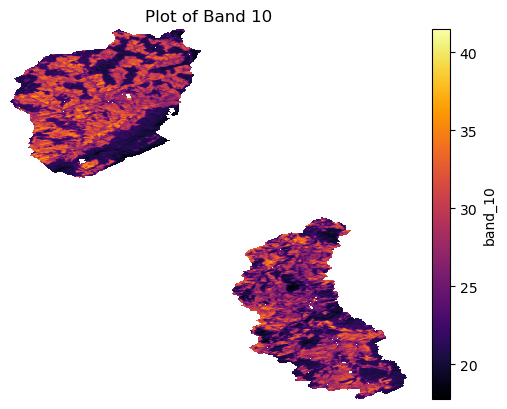

Min: 290.92303 K
Max: 314.627 K
Min: 17.77304 °C
Max: 41.47702 °C


In [ ]:
# T in Celsius

if plots == "yes": 
    band_10_cels = LS_stack.band_10 - 273.15    
    
    # Import the viridis colormap
    from matplotlib.cm import viridis, plasma, inferno
    
    # Plot the data using viridis colormap
    f, ax = plt.subplots()
    band_10_cels.plot.imshow(ax=ax, cmap=inferno)
    ax.set_axis_off()
    ax.set_title("Plot of Band 10")
    plt.show()  

    # Print max/min T
    print("Min:", np.nanmin(LS_stack.band_10.values), "K")
    print("Max:", np.nanmax(LS_stack.band_10.values), "K")
    print("Min:", np.nanmin(band_10_cels.values), "°C")
    print("Max:", np.nanmax(band_10_cels.values), "°C")





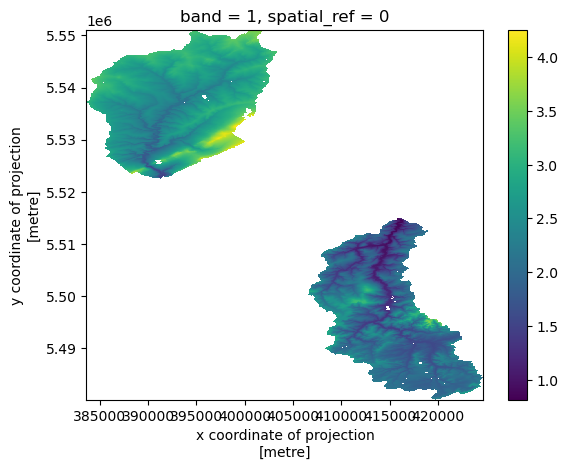

In [ ]:
## Apply DEM Correction after WASIM-Paper (Casper 2023)

L = 0.0065
LST_DEM = LS_stack.band_10 + L*DEM

LST_diff = LST_DEM - LS_stack.band_10
LST_diff.plot()

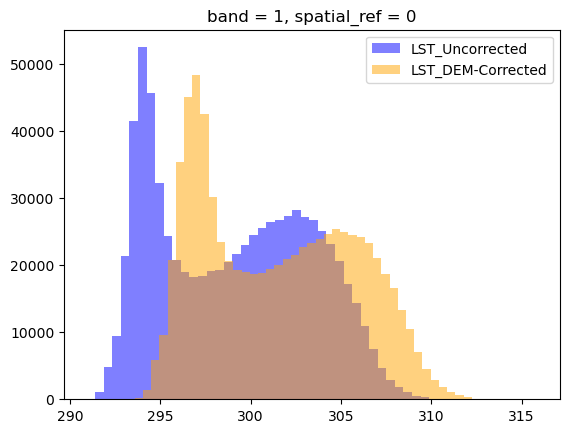

In [ ]:
LS_stack.band_10.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "LST_Uncorrected")
LST_DEM.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "LST_DEM-Corrected")
plt.legend(loc='upper right')
plt.show()

# Processing Steps

## 1. Preprocessing

### 1. Satellite Data: see above

### 2. Land Use Map

In [ ]:
# Open Corine Land Use Maps for both catchments
path_LUA = path_data + "Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = path_data + "Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()

# Merge raster
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match


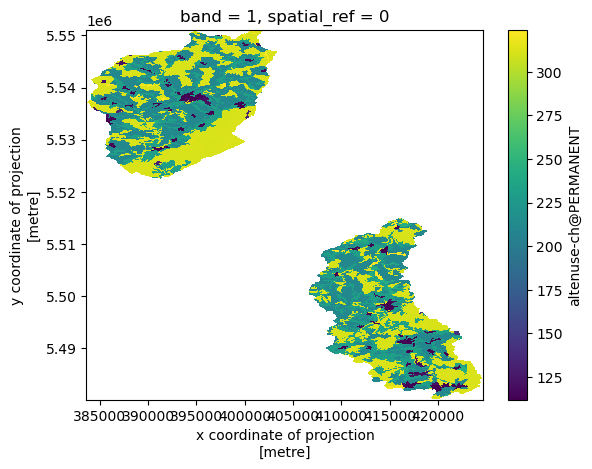

In [ ]:
# Merge rasters 
if plots == "yes": 
    LU_mosaic.plot()

In [ ]:
# Combine with Land Cover Key Table
LU_table_path = "../data/clc_legend.csv"
LU_table = pd.read_csv(LU_table_path) #delimiter = "\t", header = [3]
print(LU_table)

LU_agri = [211, 212, 221, 222, 223, 241, 242, 243, 244]
LU_bare = [331, 332, 333, 334, 131]
LU_grass = [231, 321, 322, 323, 324, 411, 412]
LU_urban = [111, 112, 121, 122, 123, 124, 132, 133, 141, 142]
LU_forest = [311, 312, 313]
LU_water = [511, 512, 335]

    GRID_CODE  CLC_CODE                         LABEL1  \
0           1       111            Artificial surfaces   
1           2       112            Artificial surfaces   
2           3       121            Artificial surfaces   
3           4       122            Artificial surfaces   
4           5       123            Artificial surfaces   
5           6       124            Artificial surfaces   
6           7       131            Artificial surfaces   
7           8       132            Artificial surfaces   
8           9       133            Artificial surfaces   
9          10       141            Artificial surfaces   
10         11       142            Artificial surfaces   
11         12       211             Agricultural areas   
12         13       212             Agricultural areas   
13         14       213             Agricultural areas   
14         15       221             Agricultural areas   
15         16       222             Agricultural areas   
16         17 

In [ ]:
# Create filters from Land Use classes
agri_filter = np.isin(LU_mosaic.values, LU_agri)
bare_filter = np.isin(LU_mosaic.values, LU_bare)
grass_filter = np.isin(LU_mosaic.values, LU_grass)
urban_filter = np.isin(LU_mosaic.values, LU_urban)
forest_filter = np.isin(LU_mosaic.values, LU_forest)
water_filter = np.isin(LU_mosaic.values, LU_water)

### 3. Meteorolocial Data

#### 3.1 Wind
Load and process wind data (Station data, one point per catchment, from WASIM Meteo Data)


C:\Users\nicol\AppData\Local\Temp\ipykernel_28976\4018496343.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wind_day = pd.Series([wind_df.loc[date][1], wind_df.loc[date][0]], index = [0,0])


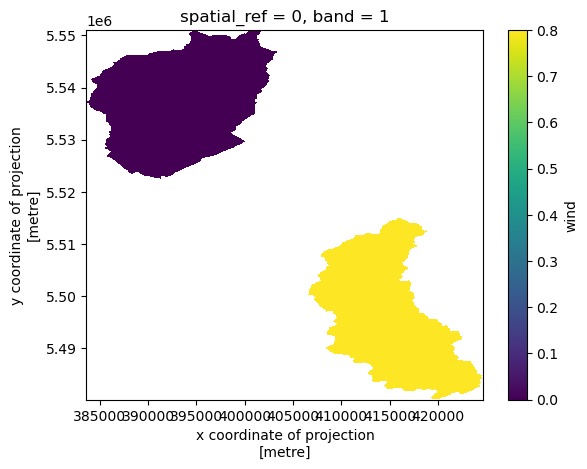

In [ ]:
# Read Wind tables from meteo data
path_meteo: str = path_data + "Processed/meteo_original/"
path_wind_alten: str = path_meteo + "Wind2010_alten.txt"
path_wind_kellen: str = path_meteo + "Wind2010_kellen.txt"
wind_alten = pd.read_csv(path_wind_alten, delimiter = "\t", header = [3])
wind_kellen = pd.read_csv(path_wind_kellen, delimiter = "\t", header = [3])

# Change Hour to Start time of day at 00:00 midnight 
wind_alten.iloc[:,3] = wind_alten.iloc[:,3]-1 
wind_kellen.iloc[:,3] = wind_kellen.iloc[:,3]-1 

# Create DateTimeIndex based on Date columns
alten_wind_date_index = pd.to_datetime(wind_alten.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")
kellen_wind_date_index = pd.to_datetime(wind_kellen.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")

# Built final wind dataframe
wind_alten_df = wind_alten.iloc[:,4].to_frame()
wind_kellen_df = wind_kellen.iloc[:,4].to_frame()

# Add Date Index
wind_alten_df = wind_alten_df.set_index([alten_wind_date_index])
wind_kellen_df = wind_kellen_df.set_index([kellen_wind_date_index])

# Outer Join for both data frames Altenbamberg and Kellenbach
wind_df = pd.concat([wind_alten_df, wind_kellen_df], axis = 1)
wind_df.columns = ["wind_altenbamberg", "wind_kellenbach"]
wind_df.index.name = "date"

# Extracting Wind Speed for respective Date and add to map per Catchment
wind_day = pd.Series([wind_df.loc[date][1], wind_df.loc[date][0]], index = [0,0])
wind_vec = shape_catchments.assign(wind = wind_day)

 
    
#################################################    
# Rasterize vector polygon with geocube
out_grid = make_geocube(
    vector_data = wind_vec,
    output_crs = LS_stack.rio.crs,
    resolution = (-30, 30)
)

# Resample raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = out_grid
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

wind_map = xds_repr_match.wind

if plots == "yes": 
    wind_map.plot()    

# Export to csv
# wind_df.to_csv("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/meteo_processed/wind_velocity.csv")



## 2. Surface Radiation Balance

### 2.1 NDVI, SAVI, LAI

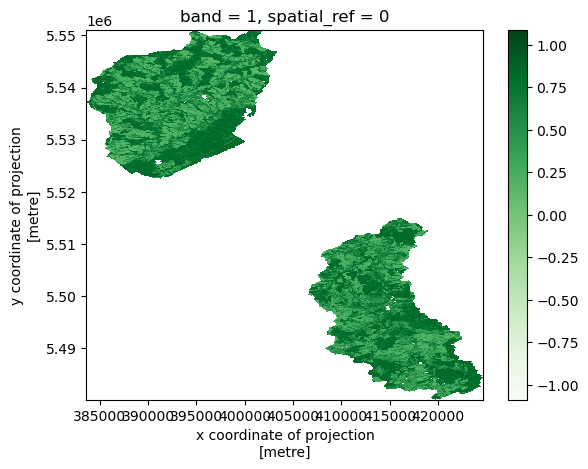

In [ ]:
# NDVI
# NDVI = (band_5 - band_4) / (band_5 + band_4)

NDVI = spyndex.computeIndex(
    index = "NDVI",
    params = {
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

if plots == "yes": 
    NDVI.plot(cmap = "Greens")

In [ ]:
# SAVI
# SAVI = (1+L_savi)*(band_5 - band_4) / (L_savi+band_5 + band_4)
L_savi = 0.5       # Value should be adjusted according to Soil Moisture (0.1 and 0.5 are suggested)

SAVI = spyndex.computeIndex(
    index = "SAVI",
    params = {
        "L": L_savi,
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

#### LAI
Calcualtion of LAI based on function from Olmedo et al. 2016 \
*"water: Tools and Functions to Estimate Actual Evapotranspiration Using Land Surface Energy Balance Models in R"*
https://journal.r-project.org/archive/2016/RJ-2016-051/index.html

In [ ]:
# Function of LAI 

def LAI_func(method):
    if method == "metric":
        LAI = -(np.log((0.69-SAVI)/0.59)/0.91) 
    elif method == "metric2010":
        LAI = 11*(SAVI**3)
    elif method == "vineyard":
        LAI = 4.9*NDVI-0.46
    elif method == "MCB":
        LAI = 1.2 - 3.08 * np.exp(-2013.35 * NDVI**6.41)
    elif method == "turner":
        LAI = 0.5724 + 0.0989 * NDVI - 0.0114 * NDVI**2 + 0.0004 * NDVI**3
    return(LAI)


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


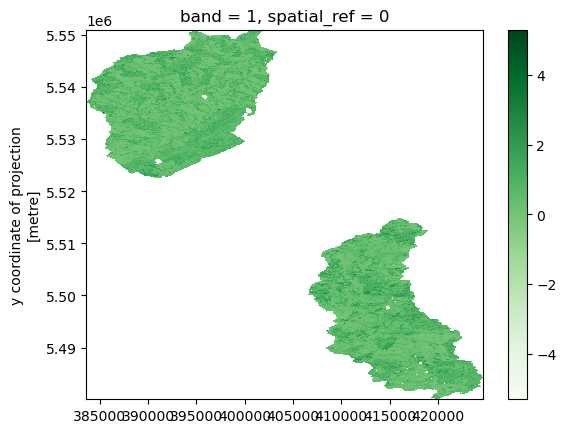

In [ ]:
# Calculate LAI with mean of two Formulas after Jaafar_2020
LAI = (LAI_func("metric") + LAI_func("metric2010")) / 2 

if plots == "yes": 
    LAI.plot(cmap = "Greens")
    
if plots == "yes":     
    LAI.plot.hist(bins = 50)

### 2.2 Albedo
Calcualtion of Albedo based on LS 8 BOA Reflectances, based on Olmedo et al. 2016 \
*"water: Tools and Functions to Estimate Actual Evapotranspiration Using Land Surface Energy Balance Models in R"*
https://journal.r-project.org/archive/2016/RJ-2016-051/index.html

In [ ]:
# Create band List for Albedo function

def create_band_list(n_bands=7):
  band_list = []
  for i in range(2, n_bands + 1):
    band_name = "band_" + str(i)
    band_list.append(band_name)
  return band_list


# Create a list with names `band_1` to `band_7`
band_list = create_band_list(n_bands=7)

# Function for Albedo with three different coefficient options
def albedo(LS_image, coeff, band_list):
    if coeff == "Tasumi":
        wb = np.array([0.254, 0.149, 0.147, 0.311, 0.103, 0.036])
    elif coeff == "Olmedo":
        wb = np.array([0.246, 0.146, 0.191, 0.304, 0.105, 0.008])
    elif coeff == "Liang":
        wb = np.array([0.356, 0, 0.13, 0.373, 0.085, 0.072])

    # Calculate the albedo for each band.
    albedo = LS_stack[band_list[0]] * wb[0]
    for i in range(1, 6):
            albedo += LS_image[band_list[i]] * wb[i]
            
    return(albedo)

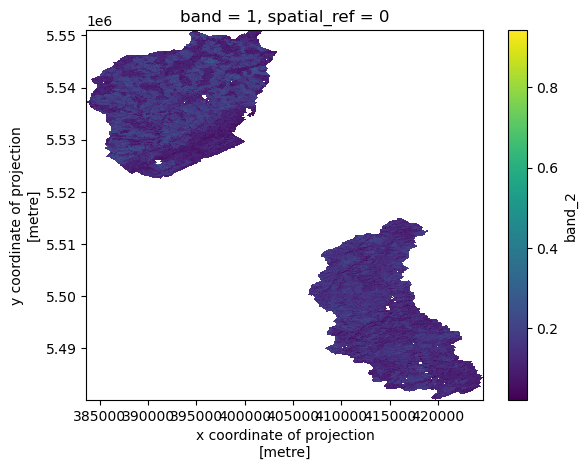

In [ ]:
# Calculate Albedo with default coefficients from "Olmedo"
albedo_unfilt = albedo(LS_stack, "Olmedo", band_list)
albedo = albedo_unfilt.where((albedo_unfilt >= 0) & (albedo_unfilt <= 1))

if plots == "yes": 
    albedo.plot()

### 2.3 Rs - Incoming Shortwave Radiation

#### 2.3.1 InterMet bigger raster, hourly
Use of Spatial, hourly Radiation Data from INTERMET (choose time closest to Landsat overpass time) \
**NOTE: Maybe need to correct time (+1h) for meteorological data, because Landsat Aquisition time is GMT --> time zone for InterMet data is yet unknown(?)**

In [ ]:
# DATA FROM InterMet/[specific date] --> hourly rasters of radiation

# Date in INTERMET-Raster Path Format with time (hour)
hour = LS_date_time.round("H").strftime("%H")
date_InterMet = date_LS + hour

# Create Path for recursive file search based on defined date
path_intermet = path_data + "Original/InterMet/"
pattern = f"*rad*{date_InterMet}*.tif"
paths_intermet_rad = sorted(glob.glob(os.path.join(path_intermet, "**", pattern), recursive=True))
print(paths_intermet_rad)

# Open INTERMET hourly Radiation Raster (biger area, catchments have to be clipped)
intermet_rad_big = rxr.open_rasterio(paths_intermet_rad[0]).squeeze()
#intermet_rad_big = intermet_rad_big.where(intermet_rad_big > 0)
#intermet_rad_alten = intermet_rad_alten.rename({"x": "long", "y": "lat"})
#intermet_rad_alten = intermet_rad_alten.sortby(["lat", "long"])
intermet_rad_big.rio.write_crs("epsg:31466", inplace=True)
intermet_rad_big.rio.write_nodata(intermet_rad_big.rio.nodata, encoded=True, inplace=True)

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/InterMet\\2020-09-19\\radiation\\Intermet_hourly_rad_2020091910.tif']


<xarray.DataArray (y: 255, x: 233)>
[59415 values with dtype=float32]
Coordinates:
    band         int32 1
  * x            (x) float64 2.502e+06 2.503e+06 ... 2.733e+06 2.734e+06
  * y            (y) float64 5.669e+06 5.668e+06 ... 5.416e+06 5.415e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  541
    STATISTICS_MEAN:     427.62252663623
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   55.525810071091
    scale_factor:        1.0
    add_offset:          0.0

In [ ]:
# Reproject intermet raster big to same CRS
intermet_rad_big = intermet_rad_big.rio.reproject(LS_stack.rio.crs)
intermet_rad_big = intermet_rad_big.where(intermet_rad_big > 0)

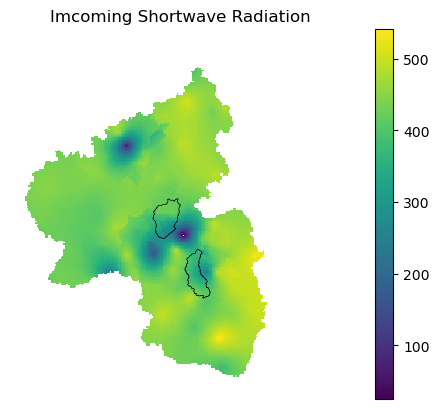

In [ ]:
# Plot Catchments within Raster

if plots == "yes": 
    f, ax = plt.subplots()
    intermet_rad_big.plot.imshow(ax=ax)

    shape_catchments.plot(ax=ax,
                        facecolor="none", 
                        linewidth=0.4)
    ax.set(title="Imcoming Shortwave Radiation")


    ax.set_axis_off()
    plt.show()

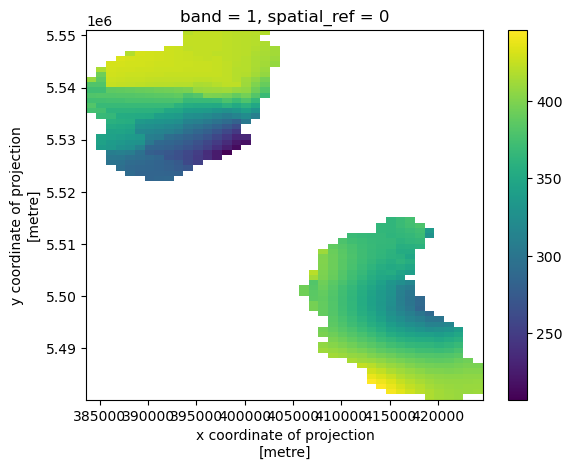

In [ ]:
# Clip raster by catchment vectors
intermet_rad_clip = intermet_rad_big.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = intermet_rad_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

intermet_rad_clip = xds_repr_match
RS_in = intermet_rad_clip

if plots == "yes": 
    intermet_rad_clip.plot()

### 2.4 RL - Outgoing Longwave Radiation

Surface Emissivity (C, 2.), Thermal Radiance (C, 3.), Surface Temperature (C, 4.) are not needed at the moment because we already got Surface Temperature from Landsat Level 2


In [ ]:
if plots == "yes": 
    print("Max LAI:", np.nanmax(LAI.values))

Max LAI: 5.297985


In [ ]:
emis_null = xr.where((LAI < 3) | LAI.isnull(), 0.95 + 0.01*LAI, 0.98)

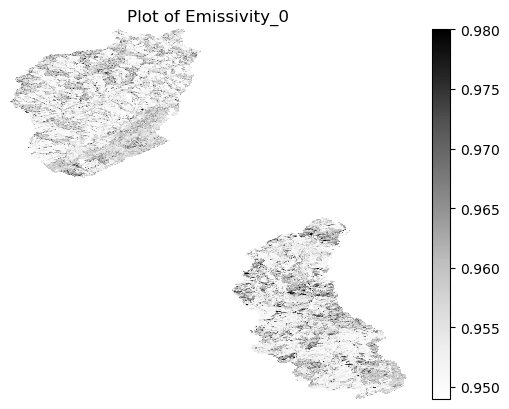

In [ ]:
if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    emis_null.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of Emissivity_0")
    plt.show()

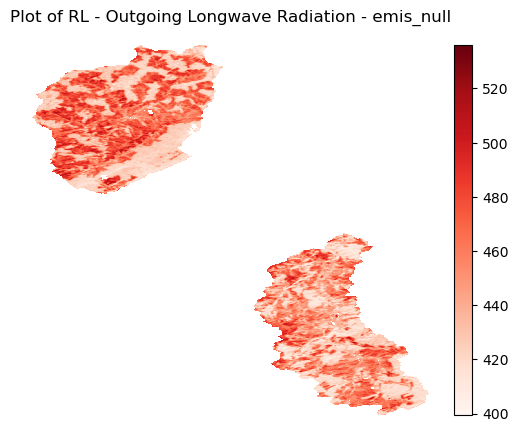

In [ ]:
# Outgoing Longwave Radiation
# typical Range: 200-700 W/m²

# Ts = LS_stack.band_10 # Old version with LST uncorrected with DEM
Ts = LST_DEM    # Surface Temperature in Kelvin, corrected with DEM 
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

RL_out = emis_null * sigma * Ts**4     # With emis_null from SEBAL_manual formulas

# Plot the data
if plots == "yes": 
    f, ax=plt.subplots()
    RL_out.plot.imshow(ax=ax,
                    cmap = "Reds")
    ax.set_axis_off()
    ax.set_title("Plot of RL - Outgoing Longwave Radiation - emis_null")
    plt.show()

### 2.5 Choosing Hot and Cold Pixel

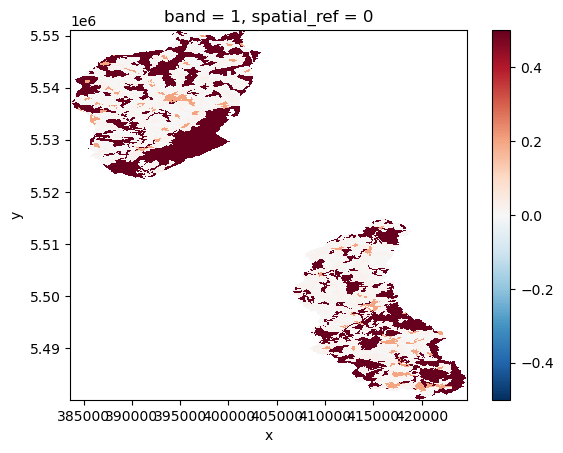

In [ ]:
# zom assigned to Land Use classes after SEBAL_Diss_knoeffel
LU_list = [LU_agri, LU_bare, LU_grass, LU_urban, LU_forest, LU_water]
zom_list = [0.018 * LAI, 0.004, 0.02, 0.2, 0.5, 0.001]

zom_map = np.nan  # Default value if none of the conditions match


for i in range(0, len(LU_list)):
    zom_map = xr.where(LU_mosaic.isin(LU_list[i]), zom_list[i], zom_map)
    
# Apply Cloud Filter also to zom_map
zom_map = zom_map.where(LS_stack_clip.QA_PIXEL.values == 21824)    
    
if plots == "yes":
    zom_map.plot()

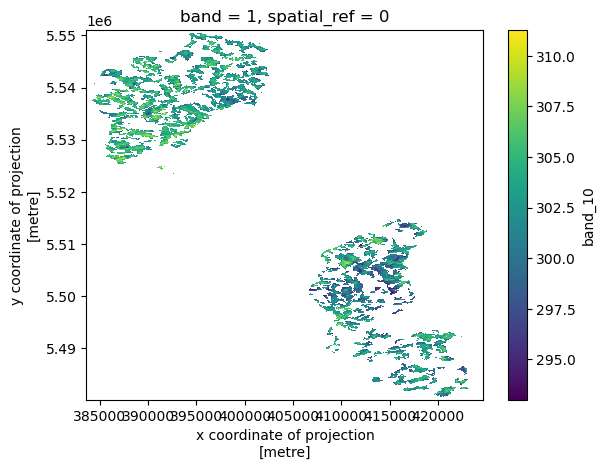

In [ ]:
# Selecting Cold/Wet Pixel
cold_px_map = LS_stack.where(agri_filter)
if plots == "yes":     
    cold_px_map.band_10.plot()

#### 2.5. A) After SEBAL_Dissertation_knoeffel_2018 and SEBAL_manual

T_cold: 294.406
Land use: 211.0 // zom_cold: 0.055952556
Overall minimum Ts: 290.92303
T_hot: 311.2671
Land use: 211.0 // zom_hot: 0.00095369737
Overall maximum Ts: 314.627


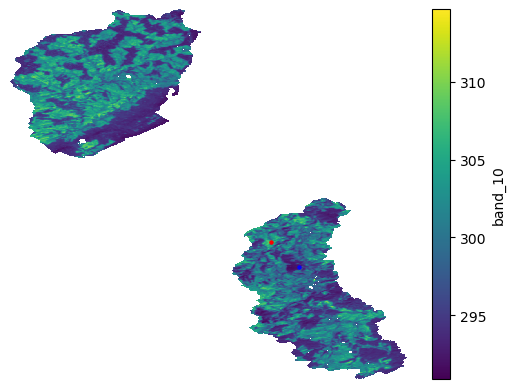

In [ ]:
## METHOD AFTER SEBAL_Dissertation_Knoeffel_2018 and SEBAL_manual

if hot_cold_selection == "A": 
    
    LAI_filt = LAI.where(agri_filter)
    filt_cold = LS_stack.band_10.where(LAI_filt > 3)
    filt_hot = LS_stack.band_10.where(LAI_filt < 1)

    # Select cold/wet pixel
    T_cold = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().values
    cold_x = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().coords["x"].values
    cold_y = filt_cold.where(filt_cold==filt_cold.min(), drop=True).squeeze().coords["y"].values
    LU_cold = LU_mosaic.where(filt_cold==filt_cold.min(), drop=True).squeeze()
    zom_cold = zom_map.sel(x = cold_x, y = cold_y)

    print("T_cold:", T_cold)
    print("Land use:", LU_cold.values, "// zom_cold:", zom_cold.values)
    print("Overall minimum Ts:", np.nanmin(LS_stack.band_10.values))



    # Selecting Hot/Dry Pixel
    T_hot = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().values
    hot_x = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().coords["x"].values
    hot_y = filt_hot.where(filt_hot==filt_hot.max(), drop=True).squeeze().coords["y"].values
    LU_hot = LU_mosaic.where(filt_hot==filt_hot.max(), drop=True).squeeze()
    zom_hot = zom_map.sel(x = hot_x, y = hot_y)


    print("T_hot:", T_hot)
    print("Land use:", LU_hot.values, "// zom_hot:", zom_hot.values)
    print("Overall maximum Ts:", np.nanmax(LS_stack.band_10.values))


    if plots == "yes":  
        # Plot the data: Hot and Cold Pixel
        f, ax=plt.subplots()
        LS_stack.band_10.plot()
        plt.scatter(cold_x, cold_y, color='blue', s=5)
        plt.scatter(hot_x, hot_y, color='red', s=5)
        ax.set_axis_off()
        ax.set_title("")
        plt.show()





#### 2.5 B) After Allen 2013 / Olmedo 2016 / Jaafar 2020
(Combination of all approaches)

In [ ]:
# Select cold/wet pixel

if hot_cold_selection == "B": 
    
    NDVI_filt = NDVI.where(agri_filter) 
    filt_cold1 = LS_stack.band_10.where(NDVI_filt.values > np.nanpercentile(NDVI_filt, 95))  # Upper 5 % NDVI
    filt_cold2 = filt_cold1.where(filt_cold1 < np.nanpercentile(filt_cold1.values, 20))  # Lowest 20 % Ts 
    filt_cold3 = filt_cold2.where((filt_cold2 >= filt_cold2.mean(skipna = True).values - 0.2) & (filt_cold2 <= filt_cold2.mean(skipna = True).values + 0.2))
    filt_cold4 = filt_cold3.where((albedo >= 0.18) & (albedo <= 0.25))



    T_cold_target = filt_cold4.median()

    ####
    # Find Cold Pixel nearest to T_cold
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/

    # calculate the difference array
    arr = filt_cold4
    difference_array = np.absolute(arr-T_cold_target)
    T_cold_coords = difference_array.min()
    cold_x = arr.where(difference_array == difference_array.min(), drop = True).min(dim="y").idxmin(dim="x").values
    cold_y = arr.where(difference_array == difference_array.min(), drop = True).min(dim="x").idxmin(dim="y").values

    # Pixel
    T_cold = filt_cold4.sel(x = cold_x, y = cold_y).values
    LU_cold = LU_mosaic.sel(x = cold_x, y = cold_y)
    zom_cold = zom_map.sel(x = cold_x, y = cold_y)

    print("T_cold_targed:", T_cold_target.values, "// T_cold:", T_cold,)
    print("Difference:", difference_array.min().values, "// Land use:", LU_cold.values)
    print("zom_cold:", zom_cold.values)
    print("Overall minimum Ts:", np.nanmin(LS_stack.band_10.values))


T_cold_targed: 294.97168 // T_cold: 294.92896
Difference: 0.04272461 // Land use: 211.0
zom_cold: 0.05503381
Overall minimum Ts: 290.92303


In [ ]:
NDVI_filt = NDVI.where(agri_filter) 
filt_cold1 = LS_stack.band_10.where(NDVI_filt.values > np.nanpercentile(NDVI_filt, 95))  # Upper 5 % NDVI
filt_cold2 = filt_cold1.where(filt_cold1 < np.nanpercentile(filt_cold1.values, 20))  # Lowest 20 % Ts 
filt_cold3 = filt_cold2.where((filt_cold2 >= filt_cold2.mean(skipna = True).values - 0.2) & (filt_cold2 <= filt_cold2.mean(skipna = True).values + 0.2))
filt_cold4 = filt_cold3.where((albedo >= 0.18) & (albedo <= 0.25))



T_cold_target = filt_cold4.median()
arr = filt_cold4
difference_array = np.absolute(arr-T_cold_target)
T_cold_coords = difference_array.min()
T_cold_coords
cold_x = arr.where(difference_array == difference_array.min(), drop = True).min(dim="y").idxmin(dim="x").values
cold_y = arr.where(difference_array == difference_array.min(), drop = True).min(dim="x").idxmin(dim="y").values
# Pixel
T_cold = filt_cold4.sel(x = cold_x, y = cold_y).values
LU_cold = LU_mosaic.sel(x = cold_x, y = cold_y)
zom_cold = zom_map.sel(x = cold_x, y = cold_y)

In [ ]:
# Select hot/dry pixel

if hot_cold_selection == "B": 
    
    NDVI_filt = NDVI.where(agri_filter) 
    filt_hot1 = LS_stack.band_10.where(NDVI_filt.values < np.nanpercentile(NDVI_filt, 10))  # Lower 10 % NDVI
    filt_hot2 = filt_hot1.where(filt_hot1 > np.nanpercentile(filt_hot1.values, 80))  # Lowest 20 % Ts 
    filt_hot3 = filt_hot2.where((filt_hot2 >= filt_hot2.mean(skipna = True).values - 0.2) & (filt_hot2 <= filt_hot2.mean(skipna = True).values + 0.2))

    T_hot_target = filt_hot3.median()

    ####
    # Find Cold Pixel nearest to T_cold
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/

    # calculate the difference array and pixel with minimum difference to T_hot_target 
    arr = filt_hot3
    difference_array = np.absolute(arr-T_hot_target)
    T_hot_coords = difference_array.min()
    # Hot Pixel candidates
    hot_x_cand = arr.where(difference_array == difference_array.min(), drop = True).squeeze().coords["x"].values 
    hot_y_cand = arr.where(difference_array == difference_array.min(), drop = True).squeeze().coords["y"].values
    


    # Pick first of all possible hot pixels candidates (could also be random)
    hot_x = hot_x_cand[0]
    hot_y = hot_y_cand[0]

    # Hot Pixel
    T_hot = filt_hot3.sel(x = hot_x, y = hot_y).values
    LU_hot = LU_mosaic.sel(x = hot_x, y = hot_y)
    zom_hot = zom_map.sel(x = hot_x, y = hot_y)

    print("T_hot_target:", T_hot_target.values, "// Count of hot pixel candidates:", hot_x_cand.size)
    print("T_hot:", T_hot)
    print("Difference:", difference_array.min().values, "// Land use:", LU_hot.values)
    print("zom_hot:", zom_hot.values)
    print("Overall maximum Ts:", np.nanmax(LS_stack.band_10.values))


T_hot_target: 307.37054 // Count of hot pixel candidates: 11
T_hot: nan
Difference: 0.0 // Land use: 312.0
zom_hot: 0.5
Overall maximum Ts: 314.627


In [ ]:
filt_hot3.median()


<xarray.DataArray 'band_10' ()>
array(307.37054, dtype=float32)
Coordinates:
    band         int32 1
    spatial_ref  int32 0

In [ ]:
NDVI_filt = NDVI.where(agri_filter) 
filt_hot1 = LS_stack.band_10.where(NDVI_filt.values < np.nanpercentile(NDVI_filt, 10))  # Lower 10 % NDVI
filt_hot2 = filt_hot1.where(filt_hot1 > np.nanpercentile(filt_hot1.values, 80))  # Lowest 20 % Ts 
filt_hot3 = filt_hot2.where((filt_hot2 >= filt_hot2.mean(skipna = True).values - 0.2) & (filt_hot2 <= filt_hot2.mean(skipna = True).values + 0.2))

T_hot_target = filt_hot3.median()

####
# Find Cold Pixel nearest to T_cold
# https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/

# calculate the difference array and pixel with minimum difference to T_hot_target 
arr = filt_hot3
difference_array = np.absolute(arr-T_hot_target)
T_hot_coords = difference_array.min()
# Hot Pixel candidates
hot_x_cand = arr.where(difference_array == difference_array.min(), drop = True).squeeze().coords["x"].values 
hot_y_cand = arr.where(difference_array == difference_array.min(), drop = True).squeeze().coords["y"].values


hot_x_cand = arr.where(difference_array == difference_array.min(), drop = True).min(dim="y").idxmin(dim="x").values
hot_y_cand= arr.where(difference_array == difference_array.min(), drop = True).min(dim="x").idxmin(dim="y").values

In [ ]:
T_hot_target = filt_hot3.median()

####
# Find Cold Pixel nearest to T_cold
# https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/

# calculate the difference array and pixel with minimum difference to T_hot_target 
arr = filt_hot3
difference_array = np.absolute(arr-T_hot_target)
difference_array.min()

<xarray.DataArray 'band_10' ()>
array(0., dtype=float32)
Coordinates:
    band         int32 1
    spatial_ref  int32 0

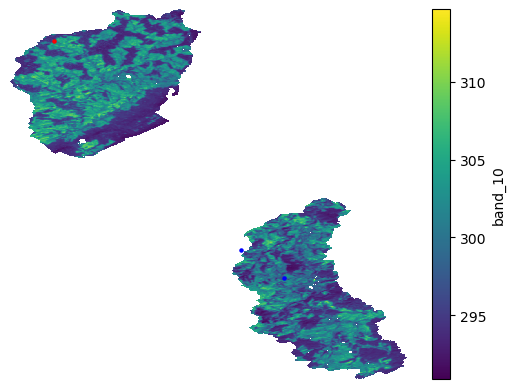

In [ ]:
if hot_cold_selection == "B":
    
    if plots == "yes":  
        # Plot the data: Hot and Cold Pixel
        f, ax=plt.subplots()
        LS_stack.band_10.plot()
        plt.scatter(cold_x, cold_y, color='blue', s=5)
        plt.scatter(hot_x, hot_y, color='red', s=5)
        ax.set_axis_off()
        ax.set_title("")
        plt.show()


## Plot Hot and Cold Pixels

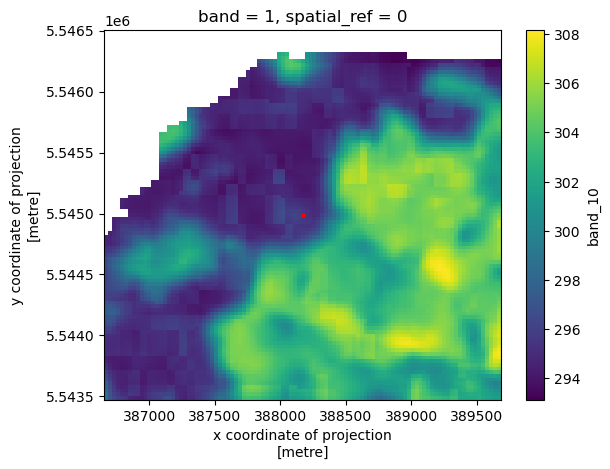

In [ ]:
hot = LS_stack.sel(x=slice(hot_x - 1500, hot_x + 1500), y=slice(hot_y + 1500, hot_y - 1500))
hot.band_10.plot()
plt.scatter(hot_x, hot_y, color='red', s=5)

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


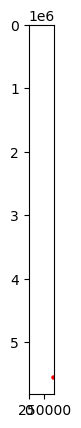

In [ ]:
# Plot array
rgb = np.dstack((hot.band_4,
                    hot.band_3,
                    hot.band_2))


# Visualize RGB
plt.imshow(rgb)
plt.scatter(hot_x, hot_y, color='red', s=5)



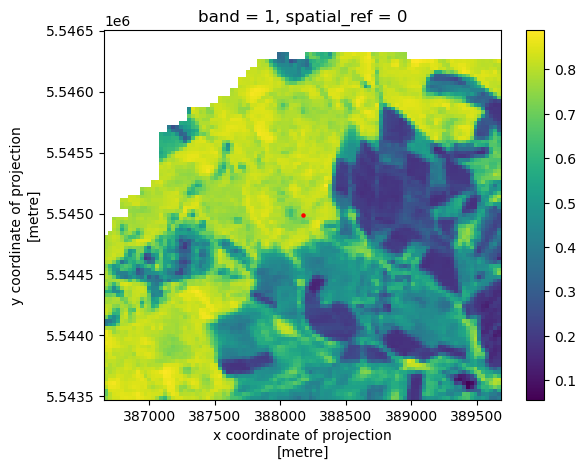

In [ ]:
hotNDVI = NDVI.sel(x=slice(hot_x - 1500, hot_x + 1500), y=slice(hot_y + 1500, hot_y - 1500))
hotNDVI.plot()
plt.scatter(hot_x, hot_y, color='red', s=5)

In [ ]:
cold = LS_stack.sel(x=slice(cold_x - 1500, cold_x + 1500), y=slice(cold_y + 1500, cold_y - 1500))
cold.band_10.plot()
plt.scatter(cold_x, cold_y, color='blue', s=5)

ValueError: cannot use non-scalar arrays in a slice for xarray indexing: [406020. 410460.]

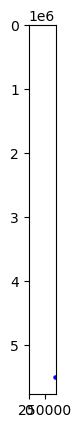

In [ ]:
# Plot array
rgb = np.dstack((cold.band_4,
                    cold.band_3,
                    cold.band_2))


# Visualize RGB
plt.imshow(rgb)
plt.scatter(cold_x, cold_y, color='blue', s=5)


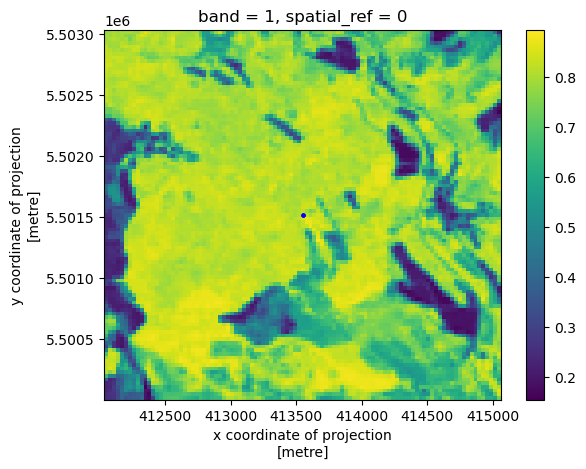

In [ ]:
coldNDVI = NDVI.sel(x=slice(cold_x - 1500, cold_x + 1500), y=slice(cold_y + 1500, cold_y - 1500))
coldNDVI.plot()
plt.scatter(cold_x, cold_y, color="blue", s=5)
plt.scatter(cold_x, cold_y, color='blue', s=5)

### 2.6.1 RL_in

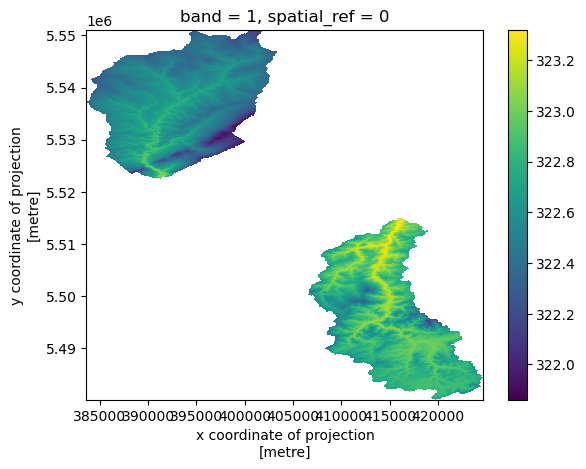

In [ ]:
# Incoming Longwave Radiation
# typical Range: 200-500 W/m²
# T_cold = np.nanmin(LS_stack.band_10.values)              # Assuming Tcold is 290 Kelvin, based on band_10 Histogram
Ta = T_cold              # Near Surface Air Temperature in Kelvin from T_cold (T Cold Pixel), since small H --> LST ~ Ta
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

# Atmospheric transmissivity  --> May also possible to use LS_stack.AtmoTrans? But probably band specific 
z = DEM     # elevation above sea level (m) with DEM  
tau_sw = 0.75+2*10**-5*z

emis_atmo = 0.85 * (-np.log(tau_sw))**0.09  # Empirical Formula for Atmospheric Emissivity # NOTE: READ on emis_atmo in env.physics page 244

RL_in = emis_atmo * sigma * Ta**4

if plots == "yes": 
    RL_in.plot()

### 2.7 Solving vor Rn

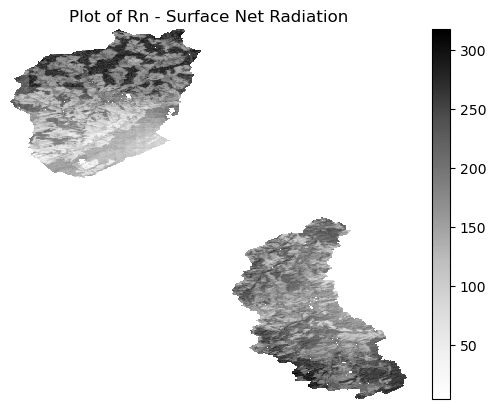

In [ ]:
# Solving for Net Surface Radiation Flux Rn
# typical Range: 100-700 W/m²

# Which RL_in to use: 
# 1. RL_in = normal SEBAL Formula  
# 2. RL_in_Landsat = with Landsat AtmoTransmissivity raster
# 3. RLin:book = with Atmospheric emissivity from ENvironmental Physics Book

Rn = (1-albedo)*RS_in + RL_in - RL_out - (1-emis_null)*RL_in  # After SEBAL Manual

# Other Formula based on Allen 2007 / M.L. Fischer Script
# Rn_allen = RS_in - (albedo*RS_in) + RL_in - RL_out - (1-emis_null)*RL_in

Rn = Rn.where(Rn > 0)

if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    Rn.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of Rn - Surface Net Radiation")
    plt.show()

## 3. Surface Energy Balance

### 3.1 G - Soil Heat Flux

In [ ]:
# Soil Heat Flux
G_Rn_ratio = ((Ts-273.16)/albedo * ((0.0038*albedo)+(0.0075*(albedo**2)))*(1-0.98*(NDVI**4)))
G = G_Rn_ratio*Rn


print("Min:", np.nanmin(G_Rn_ratio.values))
print("Max:", np.nanmax(G_Rn_ratio.values))

G_Rn_ratio_filt = G_Rn_ratio.where(G_Rn_ratio>0)
G_filt = G.where(G_Rn_ratio>0)

Min: -0.04378091827342728
Max: 0.35174690450489154


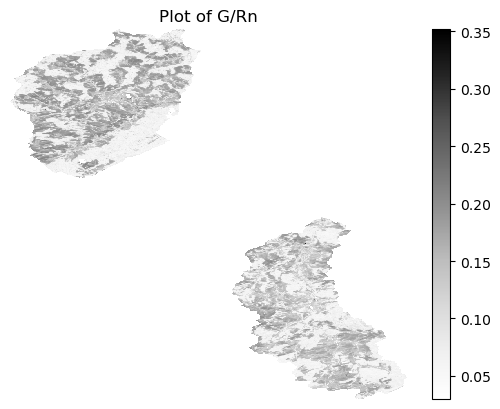

In [ ]:
if plots == "yes": 

    # Plot the data
    f, ax=plt.subplots()
    G_Rn_ratio_filt.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of G/Rn")
    plt.show()

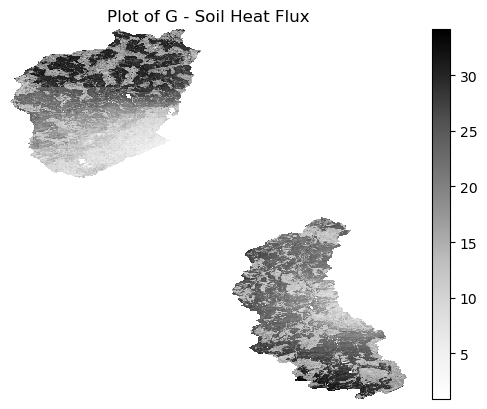

In [ ]:
if plots == "yes": 
    # Plot the data
    f, ax=plt.subplots()
    G_filt.plot.imshow(ax=ax,
                    cmap = "Greys")
    ax.set_axis_off()
    ax.set_title("Plot of G - Soil Heat Flux")
    plt.show()

### 3.2 H - Sensible Heat Flux

#### 3.2.1 Aerodynamic Resistance r_ah

u200 less than treshold value (1m/s), using 4m/s instead


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Initial r_ah at 
 Hot Pixel: 54.59273 
 Cold Pixel: 36.451202


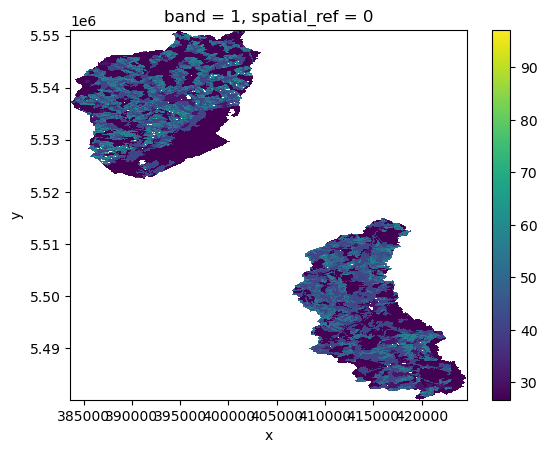

In [ ]:
if wind_method == "station":

    # OLD FORUMLAS WITH ASSUMED Wind speed and momentum roughness length 
    # r_ah for neutral stability
    # Final Formula: r_ah = (np.log(z2/z1)) / (u_asterix * k)
    # Values are just assumed for testing, later taken from actual weather data according to the station


    k = 0.41    # Karmans constant

    ux = wind_vec.wind.mean()    # Wind speed at height zx (m/s) - Mean from WInd Map (Test value was 20 m/s)
    zx = 2      # Height x with measured Wind speed ux
    h_veg = 0.3      # Vegetation Heigh in m at weather station
    zom_station = 0.12*h_veg   # momentum roughness length (m) at the weather station, SEBAL Manual suggests 0.12*height_vegetation

    # 1. Friction veolocity u_asterix --> logaritmic wind profile
    u_asterix = (k*ux) / (np.log(zx / zom_station))

    # 2. Wind speed at 200m above ground u200
    u200 = u_asterix * ((np.log(200/zom_station)) / k)

    # Treshold u200 adopted from R-Package "water" (Olmedo 2016) with 1 m/s
    if u200 < 1:
        print("u200 less than treshold value (1m/s), using 4m/s instead")
        u200 = 4.0 # m/s

    # 3. Friction Velocity u_asterix_px for each Pixel 
    zom_px =  zom_map          # Momentum roughness length (m) for each Pixel of the Image

    u_asterix_px = (k*u200) / (np.log(200 / zom_px))


    # if plots == "yes": 
    #     u_asterix_px.plot()
        
    # 4. Initial Aerodynamic resistance r_ah
    z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
    z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual

    r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

    if plots == "yes": 
        r_ah.plot()
        
        
    if plots == "yes":
        print("Initial r_ah at", "\n",
            "Hot Pixel:", r_ah.sel(x = hot_x, y = hot_y).values, "\n",
            "Cold Pixel:", r_ah.sel(x = cold_x, y = cold_y).values)    

In [ ]:
if wind_method == "map":

    # NEW FORMULA TO CALCULATE with new spatial values of Wind Speed map and Land Use based zom, see Zhang_2011_SEBAL/MODIS
    # r_ah for neutral stability
    # Final Formula: r_ah = (np.log(z2/z1)) / (u_asterix * k)
    # Values are just assumed for testing, later taken from actual weather data according to the station
    k = 0.41    # Karmans constant

    # ux = wind_map    # Wind speed at height zx (m/s) 
    zx = 2     # Height x with measured Wind speed ux, assumed to be typical weather station height (2m)

    # 1. Friction veolocity u_asterix 
    u_asterix_px = (k*wind_map) / (np.log(zx / zom_map))


        
        
        
    # 2. and 3. can be skipped due to already existing wind speed at ground level

    # 4. Initial Aerodynamic resistance r_ah
    z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
    z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual

    r_ah_windmap = (np.log(z2/z1)) / (u_asterix_px * k)

    if plots == "yes": 
        r_ah_windmap.plot()
        

    r_ah = r_ah_windmap

### Fixed Iterative h Calculation 

Probleme: \
-r_ah stabilisiert sich nicht -CHECK \
-Obukhov Länge wird -inf für Cold pixel, wo H = 0 wird - CHECK \
**FRAGE: WIRD H (hot und cold) im iterativen Prozess geupdated oder NICHT...** \
Check dafür SEBAL Manual, pySEBAL und R-Scripte: M.F. Sebal und "water" package calcH() --> habe H_hot NICHT aktualisiert, dann geht es

In [322]:
# 11. Add all steps into for loop
# Outside Loop
#######################
# INITIAL COLD PIXEL

# Working with Penman-Monteith Reference ETr for cold pixel
# Rn_cold = Rn.sel(x = cold_x, y = cold_y).values
# G_cold = G.sel(x = cold_x, y = cold_y).values
# LE_cold = 1.05 Reference ET (e.g. et_pt.sel(x = cold_x, y = cold_y).values)
# H_cold = Rn_cold - G_cold - LE_cold
r_ah_cold = r_ah.sel(x = cold_x, y = cold_y).values
roh_cold = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
cp = 1004           # Air specific heat (J/kg/K)
# dT_cold = H_cold * r_ah_cold / (roh_cold*cp) 

# Test with assumption that Hcold = 0 with zero sensible heat flux
H_cold = 0
dT_cold = 0

########################
# INITIAL HOT PIXEL
Rn_hot = Rn.sel(x = hot_x, y = hot_y).values
G_hot = G.sel(x = hot_x, y = hot_y).values
LE_hot = 0   # Assuming no rest moisture, thus no latent heat 
H_hot  = Rn_hot - G_hot - LE_hot
r_ah_hot = r_ah.sel(x = hot_x, y = hot_y).values
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
                    # Method after M.L. Fischer: roh_hot = (P *100)/ ((LST - dT) * Rs)
cp = 1004           # Air specific heat (J/kg/K)
dT_hot = H_hot * r_ah_hot / (roh_hot*cp)

# Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)

# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = T_cold
Ts_hot = T_hot

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K
g = 9.81    # Gravitational constant, m/s²

# Create Data Frame to save updated values during iteration
cols = ["Iteration", "r_ah_hot", "dT_hot", "r_ah_mean", "r_ah_cold"]
df_stabcorr = pd.DataFrame(columns=cols, index = range(15))


# Inside Loop
for i in range(15):
    # 5. Compute H from dT (near surface temperature difference)
    # Compute H and dT for hot and cold anchor pixels
    
    # COLD PIXEL
    # H_cold = Rn_cold - G_cold - LE_cold
    # r_ah_cold = r_ah.sel(x = cold_x, y = cold_y).values
    # roh_cold = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
    # cp = 1004           # Air specific heat (J/kg/K)
    # dT_cold = H_cold * r_ah_cold / (roh_cold*cp) 
    
    
    # HOT PIXEL --> already outsite the loop
    # Get r_ah for Hot Pixel after filtering r_ah non NAN
    
    
    # Or with updated H_hot from new H Map ???? (Not sure if this or initial H Value) / something like this:
    # H_hot = H.sel(x = hot_x, y = hot_y).values
    
    
    
    
    # 5.1 Linear Regression on T against dT --> get coeffiients b and a
    # Create Arrays for Linear Regression
    Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
    dT_linreg = np.array([dT_cold, dT_hot.item()])

    # Build Linear Model
    dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

    # Extract Coefficients after dT = b + a*Ts
    coeff_b = dT_model.intercept_
    coeff_a = dT_model.coef_ 
    
    # 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
    dT_pix = coeff_b + coeff_a*Ts    # or Ts_nonan
    
    # 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
    Ta_pix = Ts - dT_pix

    roh_pix = pressure / (Rs_constant * Ta_pix)

    # 7. Calculate Sensible Heat Flux H with updated r_ah
    H = (roh_pix * cp * dT_pix) / r_ah
    # H = H.where(H != 0)
    # H = H.where(H > 0)
    
    # 8. Stability correction/iteration
    # Monin-Obukhov Length L_mo
    L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)
    
    # Filter -inf values
    # L_mo = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
    #Filter after PySEBAL 
    # L_mo = L_mo.where((L_mo > -1000))
    
    # Coefficients for Corrections functions below
    x_200 = (1-(16*200/L_mo))**0.25
    x_2 = (1-(16*2/L_mo))**0.25
    x_01 = (1-(16*0.1/L_mo))**0.25

    #####################################
    # Corections for momentum psi_m and heat transport psi_h 
    #####################################
    # 1. Correction for psi_m_200
    #####################################
    # if L_mo < 0
    psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
    # if L_mo > 0
    psi_m_200_pos = -5*(2/L_mo)

    psi_m_200 = L_mo    
    psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
    psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

    #####################################
    # 2. Correction for psi_h_2
    #####################################
    # if L_mo < 0
    psi_h_2_neg = 2*np.log((1+x_2**2)/2)
    # if L_mo > 0
    psi_h_2_pos = -5*(2/L_mo)

    psi_h_2 = L_mo    
    psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
    psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 
    
    #####################################
    # 3. Correction for psi_h_01
    #####################################
    # if L_mo < 0
    psi_h_01_neg = 2*np.log((1+x_01**2)/2)
    # if L_mo > 0
    psi_h_01_pos = -5*(0.1/L_mo)

    psi_h_01 = L_mo    
    psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
    psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 
    
    #####################################
    
    # 9. UPDATE u and r_ah: Calculate corrected Friction Velocity u_asterix
    u_asterix_px = (k*u200) / (np.log(200/zom_map) - psi_m_200)
    
    # 10. UPDATE u and r_ah: Corrected Areodynamic Resistance r_ah is calculated
    r_ah = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_px * k)
    
    # 11. NEW FROM 15.11.2023 before EC: Update dT_hot with initial (not updated) H_hot but updated r_ah
    r_ah_hot = r_ah.sel(x = hot_x, y = hot_y).values
    dT_hot = H_hot * r_ah_hot / (roh_hot*cp)
    
    # 11. UPDATE dT for Hot and Cold Pixels
    # COLD
    r_ah_cold = r_ah.sel(x = cold_x, y = cold_y).values
    # H_cold = H.sel(x = cold_x, y = cold_y).values
    # # H_cold = 0
    dT_cold = H_cold * r_ah_cold / (roh_cold*cp)
    
    # # HOT
    # r_ah_hot = r_ah.sel(x = hot_x, y = hot_y).values
    # H_hot = H.sel(x = hot_x, y = hot_y).values
    # dT_hot = H_hot * r_ah_hot / (roh_hot*cp)
    
    # Save values to Stability Correction DataFrame
    df_stabcorr.loc[i].Iteration = i
    df_stabcorr.loc[i].r_ah_hot = r_ah_hot
    df_stabcorr.loc[i].dT_hot = dT_hot
    df_stabcorr.loc[i].r_ah_mean = r_ah.mean() 
    df_stabcorr.loc[i].r_ah_cold = r_ah_cold
    

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:82

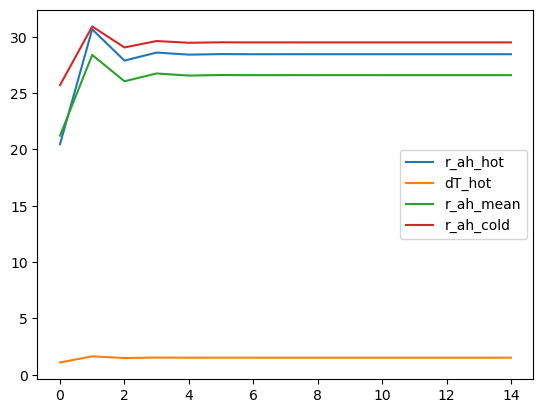

In [323]:
# Plot Change in Stability correction values
plt.plot(df_stabcorr.r_ah_hot, label = df_stabcorr.columns[1])
plt.plot(df_stabcorr.dT_hot, label = df_stabcorr.columns[2])
plt.plot(df_stabcorr.r_ah_mean, label = df_stabcorr.columns[3])
plt.plot(df_stabcorr.r_ah_cold, label = df_stabcorr.columns[4])
plt.legend()
plt.show()



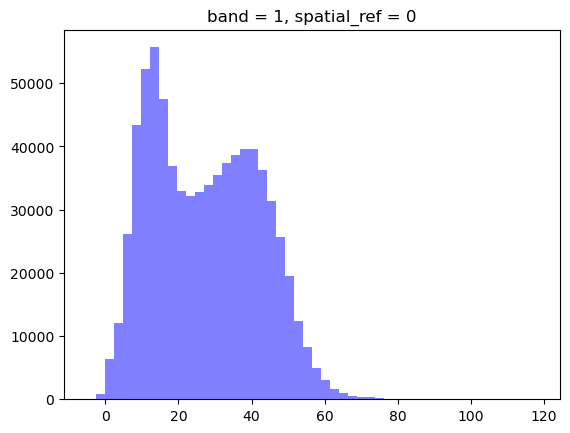

In [324]:
H.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

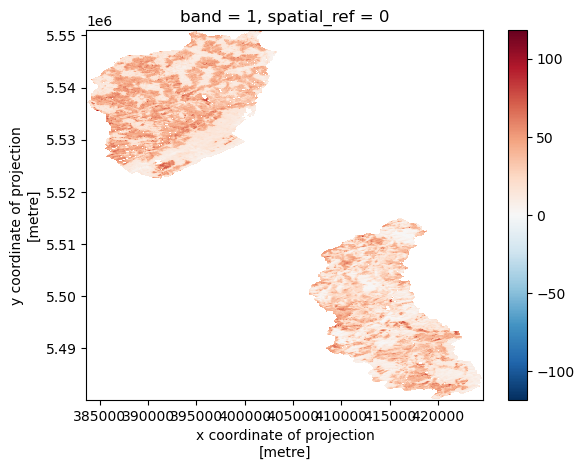

In [325]:
H.plot()

### 3.3 ET - Latent Heat Flux

In [326]:
# Calculation of ET 
ETL = Rn - G_filt - H
ETL = ETL.where(ETL>=0)


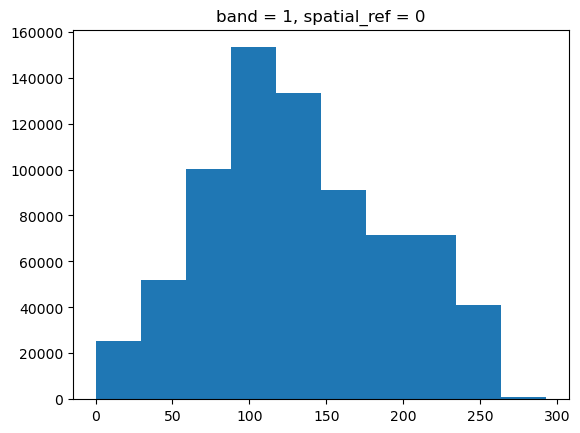

In [327]:
ETL.plot.hist()
plt.show()

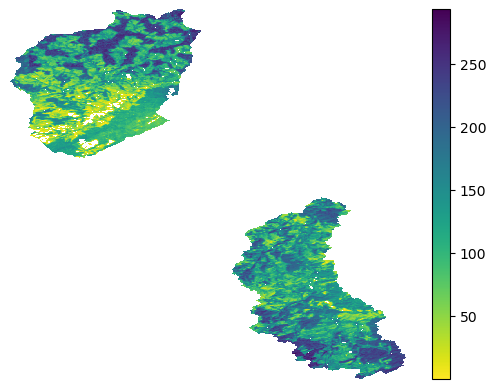

In [328]:
# Plot the data
f, ax=plt.subplots()
ETL.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

(array([ 25334.,  51935., 100200., 153209., 133415.,  91062.,  71623.,
         71482.,  40898.,   1102.]),
 array([1.50489387e-06, 4.30480987e-02, 8.60946925e-02, 1.29141286e-01,
        1.72187880e-01, 2.15234474e-01, 2.58281068e-01, 3.01327662e-01,
        3.44374255e-01, 3.87420849e-01, 4.30467443e-01]),
 <BarContainer object of 10 artists>)

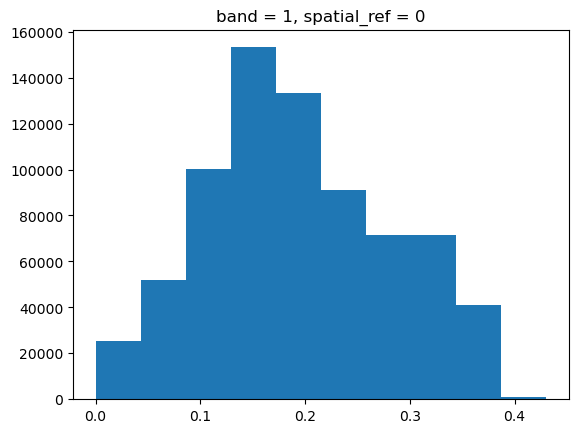

In [329]:
# From ET_lambda to ET in mm/hour
lamda = 2.45 * 10**6 # Latet heat of Vaporization J/kg
ET_inst = 3600* (ETL / lamda)

ET_inst.plot.hist()

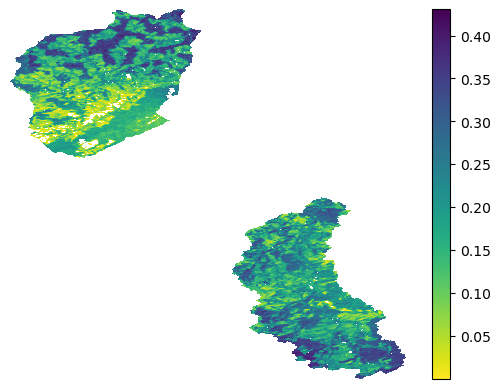

In [330]:
# Plot the data
f, ax=plt.subplots()
ET_inst.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

In [331]:
# From ET_lambda to ET in mm/hour [KNOEFFEL 2018 ANSATZ]

lambda2 = (2.501 - 0.00236 * (Ts - 273.15))*10**6
ET_inst2 = 3600 * (ETL / lambda2)



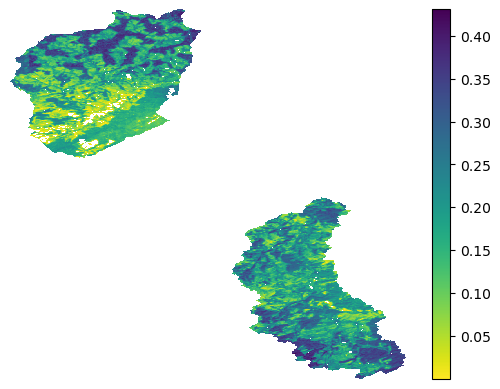

In [332]:
# Plot the data
f, ax=plt.subplots()
ET_inst2.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

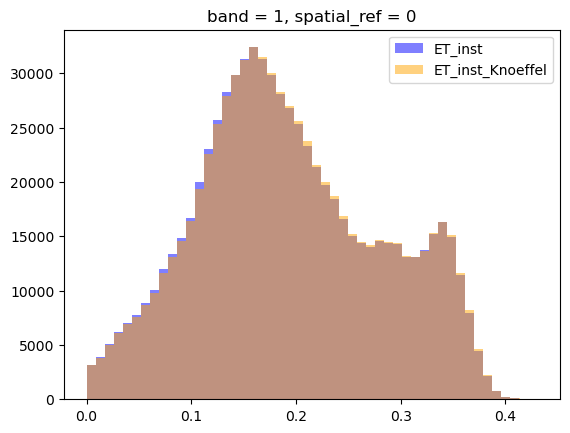

In [333]:
ET_inst.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "ET_inst")
ET_inst2.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "ET_inst_Knoeffel")
plt.legend(loc='upper right')
plt.show()

### Daily ETa Sum (with assumed constant ET-fraction)

In [334]:
# Evaporative Fraction, assumed to be constant during the day
ETf = ETL / (H + ETL)
#ETf = ETf.where((ETf > 0) & (ETf < 1))


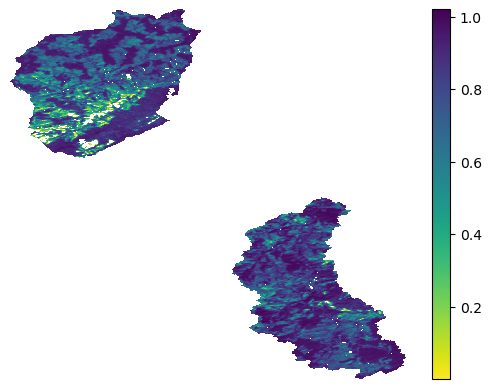

In [335]:
# Plot the data
f, ax=plt.subplots()
ETf.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

#### 3.2.0 Reference ET - Import FAO56 ET0 Rasters


In [336]:
# Import Daily ETp Rasters and Resample them

# Read Rasters
path_etp: str = path_data + "Original/meteo_raster_daily/"
path_etp_alten: str = path_etp + "ETp_FAO-56_Alten/ETp-FAO-56-Alten" + date_etp + ".tif"
path_etp_kellen: str = path_etp + "ETp_FAO-56_Kelle/ETp-FAO-56-kelle" + date_etp + ".tif"

etp_alten = rxr.open_rasterio(path_etp_alten, masked = True).squeeze()
etp_alten.rio.write_crs("epsg:31466", inplace=True)

etp_kellen = rxr.open_rasterio(path_etp_kellen, masked = True).squeeze()
etp_kellen.rio.write_crs("epsg:31466", inplace=True)


# Merge rasters
etp_mosaic = merge_arrays(dataarrays = [etp_alten, etp_kellen], nodata = np.nan)

#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
#LU_mosaic .rio.write_crs("epsg:32632", inplace=True)

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = LS_stack
xds = etp_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

etp_mosaic = xds_repr_match



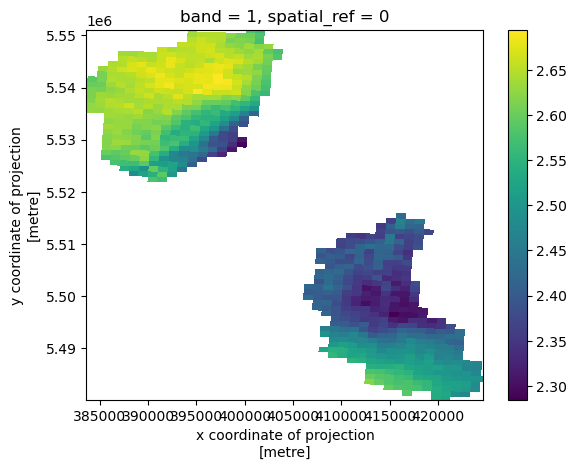

In [337]:
etp_mosaic.plot()

In [338]:
eta_day = ETf * etp_mosaic

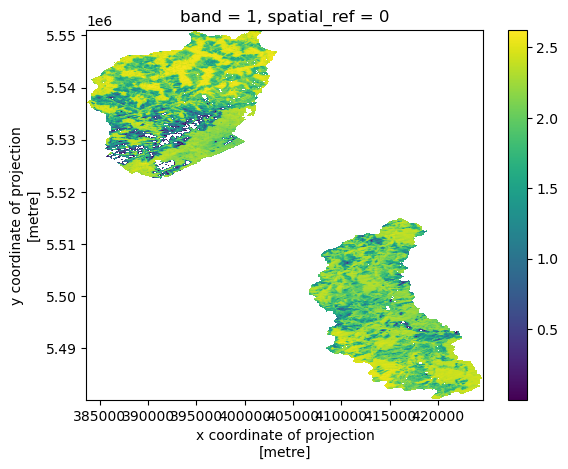

In [339]:
eta_day.plot()

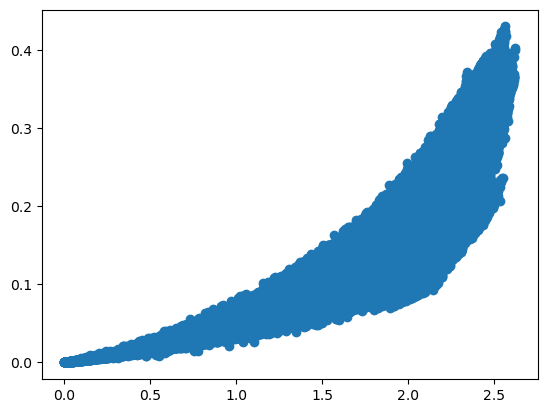

In [340]:
plt.scatter(x = eta_day, y = ET_inst)

In [341]:
# Export ETa_day Raster 
export_path = path_data + "Processed/export/eta_day/ETa_day_" + date_SSEB + ".tif"
raster = eta_day  # xarray Array to be exported

raster.rio.to_raster(export_path)